In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
%matplotlib inline
import pickle
pd.options.display.max_columns = 200

In [2]:
SEED=411 
kf = KFold(5, shuffle=True, random_state=SEED)

In [3]:
target = 'deal_probability'
y_train = pd.read_csv('data/train.csv', usecols=['activation_date', 'deal_probability'], parse_dates=['activation_date']) \
            .sort_values('activation_date') \
            .reset_index(drop=True).deal_probability.values

In [4]:
plants = pd.read_csv('all_features_plantsgo.csv.zip')

In [5]:
print(plants.shape)
plants

(2011862, 153)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,category_name_mean_price_pred,category_name_mean_price_pred_all,category_name_mean_ridge_preds,user_type_mean_price,user_type_mean_image_top_1,user_type_mean_item_seq_number,user_type_mean_price_pred,user_type_mean_price_pred_all,user_type_mean_ridge_preds,param_1_mean_price,param_1_mean_image_top_1,param_1_mean_item_seq_number,param_1_mean_price_pred,param_1_mean_price_pred_all,param_1_mean_ridge_preds,param_2_

In [6]:
#plants.drop([col for col in plants.columns if 'ridge_preds' in col], axis=1, inplace=True)        
plants.columns.tolist()

['price',
 'image_top_1',
 'item_seq_number',
 'activation_weekday',
 'avg_days_up_user',
 'avg_times_up_user',
 'n_user_items',
 'cat_features_user_id_category_name_Одежда, обувь, аксессуары',
 'cat_features_user_id_category_name_Детская одежда и обувь',
 'cat_features_user_id_category_name_Товары для детей и игрушки',
 'cat_features_user_id_category_name_Предложение услуг',
 'cat_features_user_id_category_name_Квартиры',
 'cat_features_user_id_category_name_Ремонт и строительство',
 'cat_features_user_id_category_name_Мебель и интерьер',
 'cat_features_user_id_category_name_Телефоны',
 'cat_features_user_id_category_name_Коллекционирование',
 'cat_features_user_id_category_name_Автомобили',
 'cat_features_user_id_category_name_Дома, дачи, коттеджи',
 'cat_features_user_id_category_name_Товары для компьютера',
 'cat_features_user_id_category_name_Аудио и видео',
 'cat_features_user_id_category_name_Красота и здоровье',
 'cat_features_user_id_category_name_Спорт и отдых',
 'cat_feature

In [7]:
train_plants = plants.loc[:len(y_train)-1,:]
test_plants = plants.loc[len(y_train):,:].reset_index(drop=True)
del plants; gc.collect()

64

In [8]:
train_plants.shape, test_plants.shape

((1503424, 153), (508438, 153))

In [9]:
'''
origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train_item_id = origin.sort_values('activation_date').reset_index(drop=True).item_id.values
del origin; gc.collect()

origin = pd.read_csv('data/test.csv', usecols=['item_id'])
test_item_id = origin.item_id.values
del origin; gc.collect()

train = pickle.load(open('train_selected_features', 'rb'))
test = pickle.load(open('test_selected_features', 'rb'))
train['item_id'] = train_item_id
test['item_id'] = test_item_id

train = train.merge(train_plants, on='item_id', how='left')
test = test.merge(test_plants, on='item_id', how='left')

train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

del train_plants, test_plants; gc.collect()
'''

train = train_plants
test = test_plants

origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train['activation_date'] = origin['activation_date']
train = train.sort_values('activation_date').reset_index(drop=True).drop('activation_date', axis=1)
train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
train = pd.concat([train, pickle.load(open('train_selected_features', 'rb'))], axis=1)
test = pd.concat([test, pickle.load(open('test_selected_features', 'rb'))], axis=1)

In [11]:
merged = {
    'train': train,
    'test': test,
    'y_train': y_train,
}

import pickle
pickle.dump(merged, open('merged.pkl', 'wb'))

In [12]:
print(train.shape)
train

(1503424, 226)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,...,param_3_mean_ridge_preds,user_id_nunique_parent_category_name,user_id_nunique_category_name,user_id_nunique_param_1,user_id_nunique_param_2,user_id_nunique_param_3,user_id_nunique_activation_date,user_id_activation_date_count_item_id,image_top_1_nunique_item_id,image_top_1_nunique_user_id,image_top_1_nunique_category_name,image_top_1_nunique_param_1,image_top_1_nunique_item_seq_number,image_top_1_mean_price_

In [13]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
ml = model_loader('lgb')

In [14]:
categorical = ['image_top_1', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'param_1', 
               'param_2', 'param_3', 'lat_lon_hdbscan_cluster_05_03', 'lat_lon_hdbscan_cluster_10_03', 
               'lat_lon_hdbscan_cluster_20_03',]
numerical = [f for f in train.columns.tolist() if f not in categorical]

In [15]:
rounds = 24000
early_stop_rounds = 200

params = {
    'boosting_type': 'gbdt',
    'objective': 'xentropy',
    'metric': 'rmse',
    #'min_child_weight': 1.5,
    'num_leaves': 45,
    'max_depth': 9,
    'lambda_l2': 5.9,
    'lambda_l1': 3,
    'subsample': 1.,
    'colsample_bytree': .2,
    'colsample_bylevel': 1.,
    'learning_rate': 0.02,
    'seed': 2018,
    'nthread': 4,
    'silent': True,
}

ret = np.zeros((train.shape[0],))
ret_test = np.zeros((test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(train.loc[train_ix,:], label=y_train[train_ix],)
                         #feature_name=train.columns.tolist(),
                         #categorical_feature=categorical)
    dvalid = lgb.Dataset(train.loc[val_ix,:], label=y_train[val_ix],)
                         #feature_name=train.columns.tolist(),
                         #categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(train.loc[val_ix,:])
    ret_test += model.predict(test)
    ret_models.append(model)
    
    del dtrain, dvalid
    
ret_test = ret_test / 5.

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225483	valid's rmse: 0.225692
[200]	train's rmse: 0.221605	valid's rmse: 0.221936
[300]	train's rmse: 0.219563	valid's rmse: 0.220073
[400]	train's rmse: 0.218318	valid's rmse: 0.219012
[500]	train's rmse: 0.217407	valid's rmse: 0.218277
[600]	train's rmse: 0.216683	valid's rmse: 0.217726
[700]	train's rmse: 0.216005	valid's rmse: 0.217221
[800]	train's rmse: 0.215481	valid's rmse: 0.216872
[900]	train's rmse: 0.214986	valid's rmse: 0.216551
[1000]	train's rmse: 0.214511	valid's rmse: 0.216252
[1100]	train's rmse: 0.214093	valid's rmse: 0.216003
[1200]	train's rmse: 0.213709	valid's rmse: 0.215796
[1300]	train's rmse: 0.213349	valid's rmse: 0.215596
[1400]	train's rmse: 0.213038	valid's rmse: 0.215453
[1500]	train's rmse: 0.21274	valid's rmse: 0.21532
[1600]	train's rmse: 0.212442	valid's rmse: 0.215194
[1700]	train's rmse: 0.212174	valid's rmse: 0.215088
[1800]	train's rmse: 0.21191	valid's rmse: 0.21

[15400]	train's rmse: 0.189563	valid's rmse: 0.212858
[15500]	train's rmse: 0.189419	valid's rmse: 0.212855
[15600]	train's rmse: 0.189273	valid's rmse: 0.21285
[15700]	train's rmse: 0.189124	valid's rmse: 0.212845
[15800]	train's rmse: 0.188987	valid's rmse: 0.212844
[15900]	train's rmse: 0.188848	valid's rmse: 0.212841
[16000]	train's rmse: 0.188703	valid's rmse: 0.212837
[16100]	train's rmse: 0.188561	valid's rmse: 0.212833
[16200]	train's rmse: 0.188421	valid's rmse: 0.212827
[16300]	train's rmse: 0.188279	valid's rmse: 0.212828
[16400]	train's rmse: 0.188134	valid's rmse: 0.212827
Early stopping, best iteration is:
[16263]	train's rmse: 0.188334	valid's rmse: 0.212825
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225301	valid's rmse: 0.226486
[200]	train's rmse: 0.221375	valid's rmse: 0.222768
[300]	train's rmse: 0.219323	valid's rmse: 0.220887
[400]	train's rmse: 0.218094	valid's rmse: 0.21983
[500]	train's rmse: 0.217187	valid's rmse: 0.219

[14100]	train's rmse: 0.191333	valid's rmse: 0.2136
[14200]	train's rmse: 0.191195	valid's rmse: 0.2136
[14300]	train's rmse: 0.191044	valid's rmse: 0.213597
[14400]	train's rmse: 0.190904	valid's rmse: 0.213599
Early stopping, best iteration is:
[14294]	train's rmse: 0.191053	valid's rmse: 0.213597
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225633	valid's rmse: 0.225014
[200]	train's rmse: 0.221724	valid's rmse: 0.221366
[300]	train's rmse: 0.219669	valid's rmse: 0.219545
[400]	train's rmse: 0.218428	valid's rmse: 0.218511
[500]	train's rmse: 0.217529	valid's rmse: 0.217804
[600]	train's rmse: 0.21679	valid's rmse: 0.21726
[700]	train's rmse: 0.216118	valid's rmse: 0.216776
[800]	train's rmse: 0.215606	valid's rmse: 0.216449
[900]	train's rmse: 0.215112	valid's rmse: 0.216135
[1000]	train's rmse: 0.21464	valid's rmse: 0.215843
[1100]	train's rmse: 0.214218	valid's rmse: 0.215592
[1200]	train's rmse: 0.213845	valid's rmse: 0.215394
[1300]	train

[14800]	train's rmse: 0.190665	valid's rmse: 0.212504
[14900]	train's rmse: 0.190522	valid's rmse: 0.212501
[15000]	train's rmse: 0.190377	valid's rmse: 0.212499
[15100]	train's rmse: 0.190229	valid's rmse: 0.212496
[15200]	train's rmse: 0.190076	valid's rmse: 0.212492
[15300]	train's rmse: 0.189929	valid's rmse: 0.212488
[15400]	train's rmse: 0.18978	valid's rmse: 0.212485
[15500]	train's rmse: 0.189649	valid's rmse: 0.212482
[15600]	train's rmse: 0.189511	valid's rmse: 0.212478
[15700]	train's rmse: 0.18937	valid's rmse: 0.212475
[15800]	train's rmse: 0.189222	valid's rmse: 0.21247
[15900]	train's rmse: 0.189088	valid's rmse: 0.212464
[16000]	train's rmse: 0.188944	valid's rmse: 0.212462
[16100]	train's rmse: 0.188805	valid's rmse: 0.212461
[16200]	train's rmse: 0.188666	valid's rmse: 0.212456
[16300]	train's rmse: 0.188528	valid's rmse: 0.212454
[16400]	train's rmse: 0.188384	valid's rmse: 0.212452
[16500]	train's rmse: 0.188242	valid's rmse: 0.212449
[16600]	train's rmse: 0.188101	

[12200]	train's rmse: 0.194366	valid's rmse: 0.212714
[12300]	train's rmse: 0.194222	valid's rmse: 0.212714
[12400]	train's rmse: 0.194073	valid's rmse: 0.212713
[12500]	train's rmse: 0.193925	valid's rmse: 0.212707
[12600]	train's rmse: 0.193777	valid's rmse: 0.212704
[12700]	train's rmse: 0.193626	valid's rmse: 0.212701
[12800]	train's rmse: 0.19348	valid's rmse: 0.212691
[12900]	train's rmse: 0.193329	valid's rmse: 0.212684
[13000]	train's rmse: 0.193186	valid's rmse: 0.212682
[13100]	train's rmse: 0.19304	valid's rmse: 0.212678
[13200]	train's rmse: 0.19289	valid's rmse: 0.212674
[13300]	train's rmse: 0.19274	valid's rmse: 0.212671
[13400]	train's rmse: 0.192592	valid's rmse: 0.21267
[13500]	train's rmse: 0.192462	valid's rmse: 0.212665
[13600]	train's rmse: 0.192318	valid's rmse: 0.212664
[13700]	train's rmse: 0.192171	valid's rmse: 0.212658
[13800]	train's rmse: 0.192026	valid's rmse: 0.212657
[13900]	train's rmse: 0.191878	valid's rmse: 0.212653
[14000]	train's rmse: 0.191734	va

[8000]	train's rmse: 0.200597	valid's rmse: 0.213763
[8100]	train's rmse: 0.200445	valid's rmse: 0.21375
[8200]	train's rmse: 0.20029	valid's rmse: 0.213742
[8300]	train's rmse: 0.20013	valid's rmse: 0.213733
[8400]	train's rmse: 0.199973	valid's rmse: 0.213723
[8500]	train's rmse: 0.199824	valid's rmse: 0.213713
[8600]	train's rmse: 0.19967	valid's rmse: 0.213704
[8700]	train's rmse: 0.199516	valid's rmse: 0.213694
[8800]	train's rmse: 0.199355	valid's rmse: 0.213688
[8900]	train's rmse: 0.199203	valid's rmse: 0.213681
[9000]	train's rmse: 0.199049	valid's rmse: 0.21367
[9100]	train's rmse: 0.19889	valid's rmse: 0.213659
[9200]	train's rmse: 0.198733	valid's rmse: 0.213653
[9300]	train's rmse: 0.198593	valid's rmse: 0.213647
[9400]	train's rmse: 0.198425	valid's rmse: 0.213633
[9500]	train's rmse: 0.198267	valid's rmse: 0.213624
[9600]	train's rmse: 0.198111	valid's rmse: 0.213617
[9700]	train's rmse: 0.197965	valid's rmse: 0.21361
[9800]	train's rmse: 0.197802	valid's rmse: 0.213603


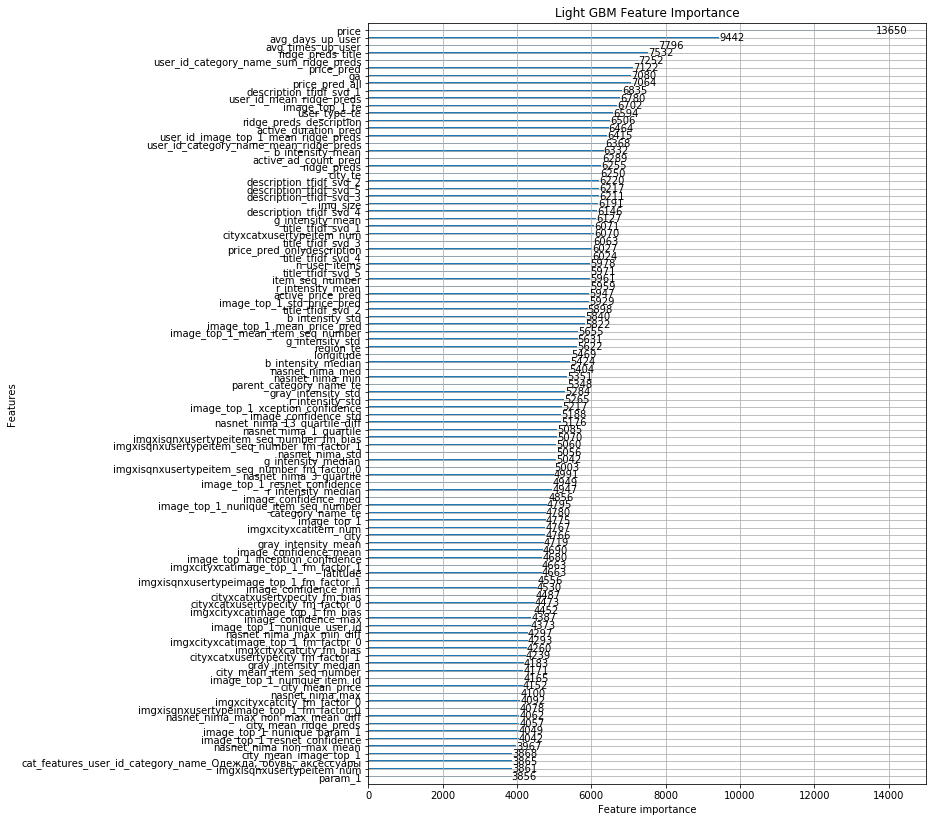

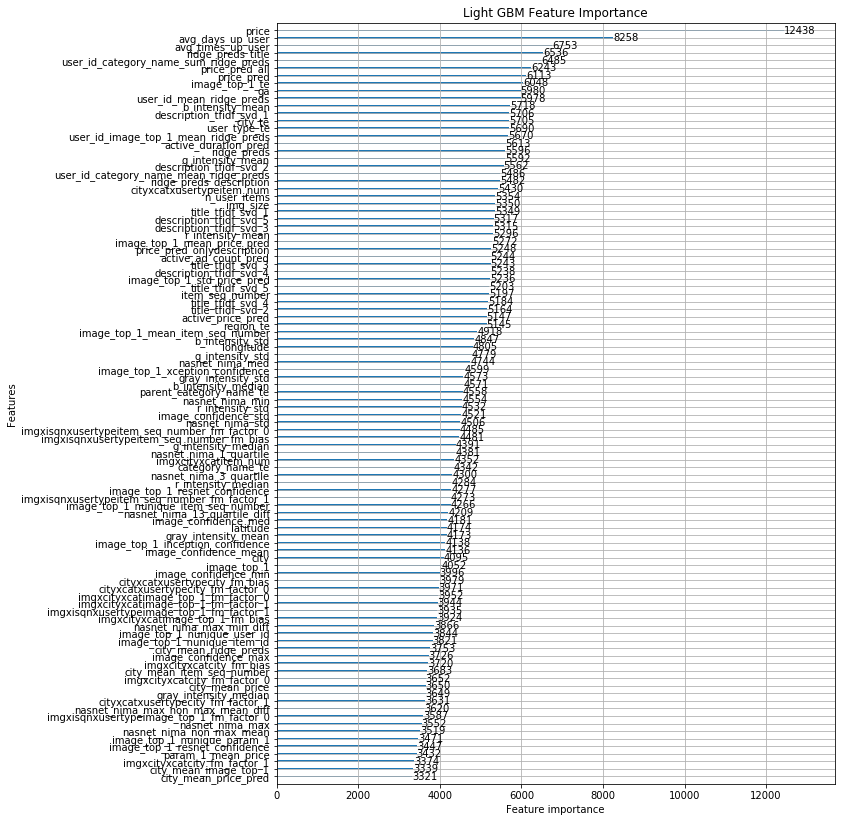

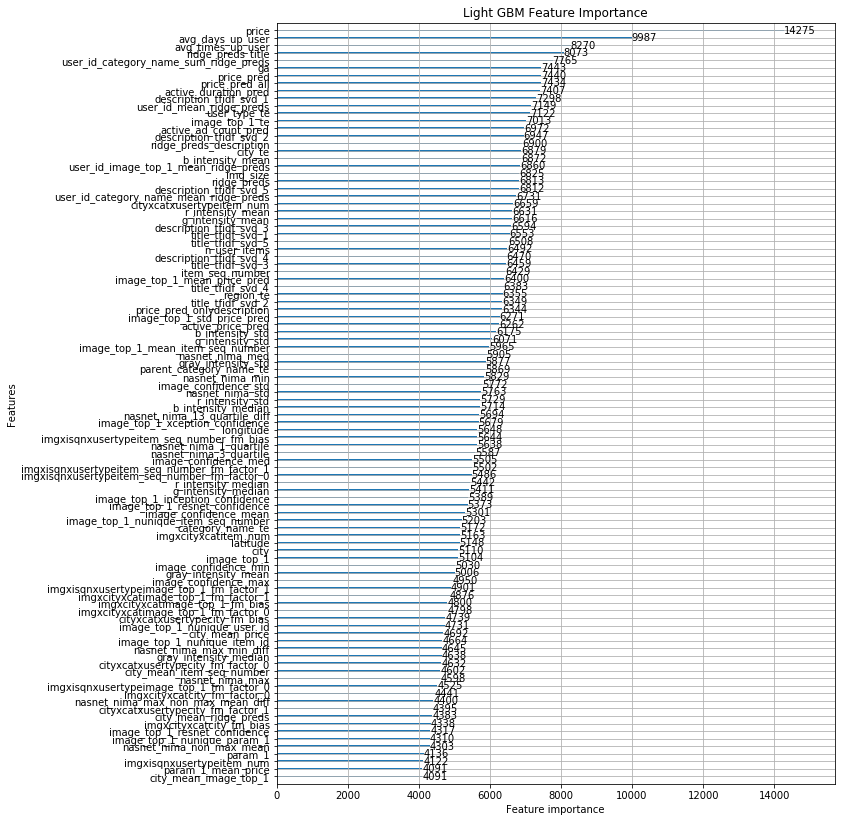

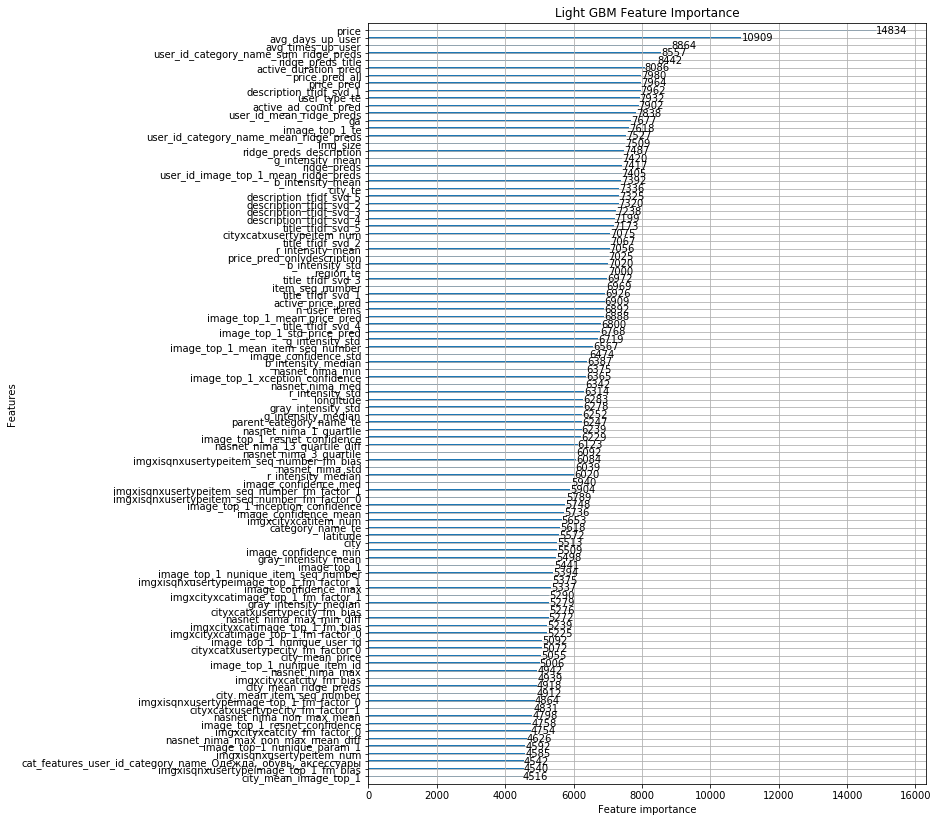

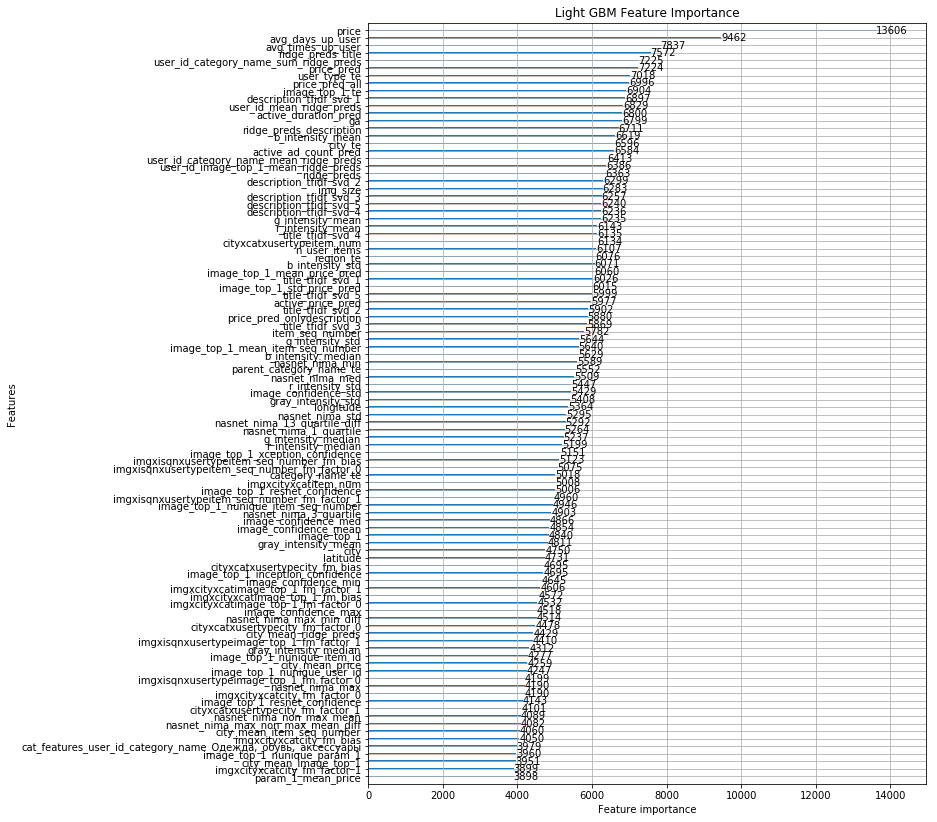

In [16]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=100, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

In [17]:
prefix = 'xentropy_add_img_conf_lgb'

In [18]:
pd.DataFrame(data=ret, columns=[prefix+'_pred']).to_csv(prefix+'_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=[prefix+'_pred']).to_csv(prefix+'_oof_test_pred.csv', index=False)

In [19]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv(prefix+'_submission.csv', index=False)

In [20]:
# origin: cv: .215172, lb: .2196
# with img meta+nima+fm+active: cv: .214405  lb: .2189
# with xentropy: cv: 0.213726  lb: 
# smaller lr (0.1 => 0.02): cv:.212952  lb: .2181
# finetuned: cv: .2124, lb: .2179
# new nima: cv:  lb: